## Mental Health in the Tech Industry

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import RFECV
import warnings
import seaborn as sns
plt.style.use('seaborn')

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)

In [2]:
#Loading Data 
df=pd.read_csv('./data/survey.csv')

In [3]:
# Fixing column Names
df.columns=[x.lower() for x in df.columns]

In [4]:
# Dropping self employed since its not relevant to the buisiness question.
df.drop(list(df[df.self_employed=='Yes'].index),inplace=True)
df.drop('comments',axis=1,inplace=True)

In [5]:
# Cleaning the datetime column
df['timestamp']=[" ".join(x[:-9].split('-')).replace(" ","-") for x in df.timestamp]

In [6]:
# make all answers lowercase
df.gender = df.gender.str.lower()

# create three lists male, female and other of all the entries
male = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "cis male"]
female = ["cis female", "f", "female", "woman", "femake", "female ","cis-female/femme", "female (cis)", "femail"]
gender_variant = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", 
     "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", 
     "female (trans)", "queer", "ostensibly male, unsure what that really means", "p", "a little about you"]

# use .loc and .isin to map male, female and gender variant to
df.gender.loc[df.gender.isin(male)] = 'male'
df.gender.loc[df.gender.isin(female)] = 'female'
df.gender.loc[df.gender.isin(gender_variant)] = 'gender_variant'

In [7]:
# Binning Companies employees size to better interpret later.
conditions=[
    df.no_employees=="1-5",            
    df.no_employees=="6-25",         
    df.no_employees=="26-100", 
    df.no_employees=="100-500",       
    df.no_employees=="500-1000" ,           
    df.no_employees=="More than 1000",
]
choices=[
    "extra_small",
    "small",
    "medium",
    "medium_large",
    "large",
    "extra_large",
    
]
df['no_employees']=np.select(conditions,choices,default=0)

In [8]:
# Making our target feature binary.
conditions=[
    (df["mental_health_consequence"].str.lower()=='yes'),            
    (df["mental_health_consequence"].str.lower()=='no'),
    (df["mental_health_consequence"].str.lower()=='maybe')|(df["mental_health_consequence"].str.lower()=='don\'t know')|(df["mental_health_consequence"].str.lower()=='not sure'),
]
choises=[
    1,
    0,
    1,

]
df["mental_health_consequence"]=np.select(conditions,choises,default=0)

### Visualize Binary Target

In [60]:
# create binary target variable graph
binary_target = df['mental_health_consequence'].value_counts().to_frame() # create df for target
binary_target.rename({1:'Yes', 0:'No'}, inplace=True) # rename rows to Yes/No
melt_bin_tar = pd.melt(binary_target.reset_index(), id_vars='index') # melt df for bar graph
melt_bin_tar

,index,variable,value
0,Yes,mental_health_consequence,689
1,No,mental_health_consequence,415


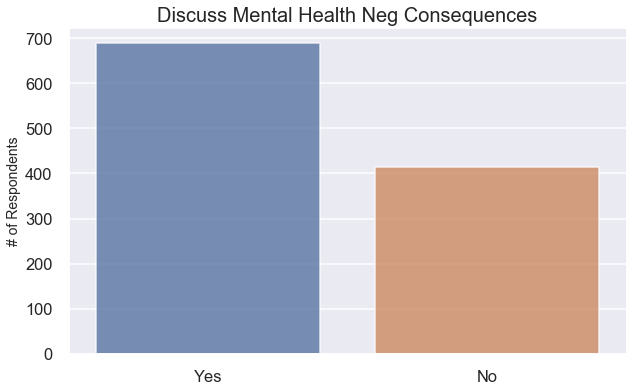

In [64]:
# plot binary target
sns.set('talk')
plt.figure(figsize=(10,6))
sns.barplot(x=melt_bin_tar['index'], y=melt_bin_tar['value'], alpha = .80)
plt.title('Discuss Mental Health Neg Consequences', fontdict={'fontsize':20})
plt.ylabel('# of Respondents', fontdict={'fontsize':14})
plt.xlabel('')
plt.savefig('binary_target', dpi=300)

In [65]:
# express binary target as percentage
melt_bin_tar['percent'] = round(melt_bin_tar['value']/sum(melt_bin_tar['value']) * 100,2)

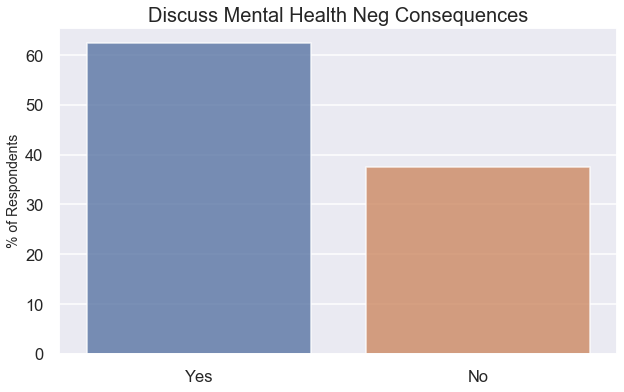

In [66]:
# plot binary target as percentage
sns.set('talk')
plt.figure(figsize=(10,6))
sns.barplot(x=melt_bin_tar['index'], y=melt_bin_tar['percent'], alpha = .80)
plt.title('Discuss Mental Health Neg Consequences', fontdict={'fontsize':20})
plt.ylabel('% of Respondents', fontdict={'fontsize':14})
plt.xlabel('')
plt.savefig('binary_target_percent', dpi=300)

In [11]:
# Making our Nan values Missing to add more information to the model that people may have felt uncomfortable 
# answering the questions at hand .

df.work_interfere=df.work_interfere.fillna("Missing")
df.self_employed=df.self_employed.fillna("Missing")

In [12]:
# Binning countries location to better interpret the results from each area of the globe.
north=['Canada','United States']
uk=['United Kingdom']
eu=['Germany','Ireland','Netherlands','France','Italy','Belgium','Spain','Norway']
for x in df.country.index:
    if df.country[x]in north:
        df.country[x]= "North America"
    elif df.country[x]in uk:
        df.country[x]= "United Kingdom"
    elif df.country[x]in eu:
        df.country[x]= "Europe"
    else:
        df.country[x]= 'Other'

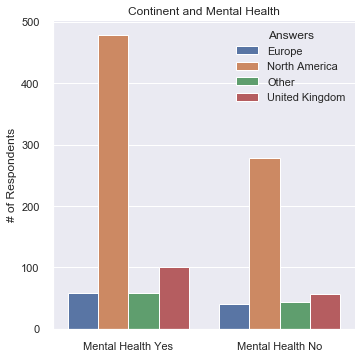

In [13]:
# graph continent feature against target
continent_yes = df['country'].loc[df['mental_health_consequence'] == 1].value_counts().to_frame() # yes continent df
continent_no = df['country'].loc[df['mental_health_consequence'] == 0].value_counts().to_frame() # no continent df

# create df with yes and no continent
continent_df = pd.DataFrame({'mental_health_yes':continent_yes['country'],
                            'mental_health_no':continent_no['country']})
continent_df.index.name = 'Answers'
continent_df.reset_index(inplace=True)

# melt df for bar graph
continent_df = pd.melt(continent_df, id_vars='Answers', var_name='mental_health_yes', value_name='mental_health_no')

# plot melted df
sns.set(style='darkgrid')
sns.catplot(x='mental_health_yes', y='mental_health_no', hue='Answers', data=continent_df, kind='bar', legend_out=False)\
    .set(ylabel='# of Respondents', xlabel='', title='Continent and Mental Health')\
    .set_xticklabels(['Mental Health Yes', 'Mental Health No'])
plt.savefig('./images/continent_mental_health', dpi=300)

In [14]:
# Binning each state to be able to analize how each region may affect mental health. 

north= ['CT', 'DE', 'IL', 'IN', 'IA', 'KS', 'ME', 'MA', 'MD', 'MI', 'MN', 'MO', 'NE','NH', 'NJ', 'NY', 'ND', 'OH', 'PA', 'RI', 'SD', 'VT', 'WI','DC']
south= ['AL', 'AR', 'FL', 'GA', 'KT', 'LA', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV', 'PR']
west= ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']


for x in df.state.index:
    if df.state[x]in north:
        df.state[x]= "Northern State"
    elif df.state[x]in south:
        df.state[x]= "Southern State"
    elif df.state[x]in west:
        df.state[x]= "Western State"
    else:
        df.state[x]= 'Non US'

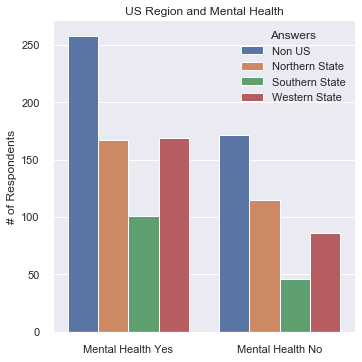

In [15]:
# graph region feature against target
regional_yes = df['state'].loc[df['mental_health_consequence'] == 1].value_counts().to_frame() # yes regional df
regional_no = df['state'].loc[df['mental_health_consequence'] == 0].value_counts().to_frame() # no regional df

# create df with yes and no region
regional_df = pd.DataFrame({'mental_health_yes':regional_yes['state'],
                            'mental_health_no':regional_no['state']})
regional_df.index.name = 'Answers'
regional_df.reset_index(inplace=True)

# melt df for bar graph
regional_df = pd.melt(regional_df, id_vars='Answers', var_name='mental_health_yes', value_name='mental_health_no')

# plot melted df
sns.set(style='darkgrid')
sns.catplot(x='mental_health_yes', y='mental_health_no', hue='Answers', data=regional_df, kind='bar', legend_out=False)\
    .set(ylabel='# of Respondents', xlabel='', title='US Region and Mental Health')\
    .set_xticklabels(['Mental Health Yes', 'Mental Health No'])
plt.savefig('./images/us_region_mental_health', dpi=300)

In [16]:
# Creating dummies for our models.
df=pd.get_dummies(df,columns=['no_employees','gender','country','state','work_interfere','benefits','care_options','wellness_program','seek_help','anonymity','leave','phys_health_consequence','coworkers','supervisor','mental_health_interview','phys_health_interview','mental_vs_physical',"self_employed"],)

In [17]:
# Manually dropping the columns from our dummies. We selected the tertiary answers as the ones to drop.
df.drop(["state_Non US","no_employees_extra_small",'gender_gender_variant','country_Other',"work_interfere_Missing","benefits_Don't know","care_options_Not sure","wellness_program_Don't know","seek_help_Don't know","anonymity_Don't know","leave_Don't know","phys_health_consequence_Maybe",'coworkers_Some of them',"supervisor_Some of them","mental_health_interview_Maybe","phys_health_interview_Maybe","mental_vs_physical_Don't know",'self_employed_Missing'],axis=1,inplace=True)

In [18]:
def binary(column):
    """
    Converts Yes or No answers into variables.
    """
    conditions=[
        (df[column].str.lower()=='yes'),            
        (df[column].str.lower()=='no'),
    ]
    choises=[
        1,
        0,

    ]
    df[column]=np.select(conditions,choises,default=0)

In [19]:
# Converting our columns into binaries. 
columns=["family_history","treatment","remote_work","tech_company","obs_consequence"]
for c in columns:
    binary(str(c))

In [20]:
# Function to find outliers in Age column
def outliers(df):
    '''Takes in a dataframe and returns a list of outliers > 99th and < 1 percentile'''
    outliers = []
    for i in df:
        q1 = np.percentile(df, .5)
        q3 = np.percentile(df, 99.5)
        if i > q3 or i < q1:
            outliers.append(i)
    print("Outliers:", outliers)
    return outliers

In [21]:
# Removing the age outliers.
age_outliers = outliers(df['age'])
df = df.loc[~df['age'].isin(age_outliers)]

Outliers: [-29, 60, 329, 58, 62, -1726, 5, 72, 60]


In [22]:
# Transforming our date time column into a timestamp to be able to create dummies.
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [23]:
# create columns for years, months, days, dow, hour to see when majority of surveys were administered
df['Year'] = df['timestamp'].dt.year
df['Month'] = df['timestamp'].dt.month
df['Day'] = df['timestamp'].dt.day
df['Dow'] = df['timestamp'].dt.dayofweek

In [24]:
# Final Dataset to begin generating models.
df.head(5)

,timestamp,age,family_history,treatment,remote_work,tech_company,mental_health_consequence,obs_consequence,no_employees_extra_large,no_employees_large,no_employees_medium,no_employees_medium_large,no_employees_small,gender_female,gender_male,country_Europe,country_North America,country_United Kingdom,state_Northern State,state_Southern State,state_Western State,work_interfere_Never,work_interfere_Often,work_interfere_Rarely,work_interfere_Sometimes,benefits_No,benefits_Yes,care_options_No,care_options_Yes,wellness_program_No,wellness_program_Yes,seek_help_No,seek_help_Yes,anonymity_No,anonymity_Yes,leave_Somewhat difficult,leave_Somewhat easy,leave_Very difficult,leave_Very easy,phys_health_consequence_No,phys_health_consequence_Yes,coworkers_No,coworkers_Yes,supervisor_No,supervisor_Yes,mental_health_interview_No,mental_health_interview_Yes,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_No,mental_vs_physical_Yes,self_employed_No,Year,Month,Day,Dow
0,2014-08-27,37,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,2014,8,27,2
1,2014-08-27,44,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,2014,8,27,2
2,2014-08-27,32,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,1,0,0,2014,8,27,2
3,2014-08-27,31,1,1,0,1,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,2014,8,27,2
4,2014-08-27,31,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,2014,8,27,2


## Logistic Regression

In [25]:
#generating our X and Y variables.
x=df.drop(['timestamp','mental_health_consequence'],axis=1)
y=df.mental_health_consequence

In [26]:
# Creating our first split
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=2020,test_size=0.2)

In [27]:
# Fitting our model
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(class_weight='balanced')
lr.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

In [28]:
# Generating Predictions
y_pred_lr = lr.predict(X_test)

In [29]:
# Pulling out our scores.
from sklearn import metrics
print('Logistic Regression Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred_lr)))
print('Logistic Regression Accuracy: {}'.format(metrics.f1_score(y_test,y_pred_lr)))

Logistic Regression Accuracy: 0.8597285067873304
Logistic Regression Accuracy: 0.8904593639575972


In [30]:
# Creating a DF were we can identify which coeficient goes with each feature.
coef=list(lr.coef_[0])
col=x.columns
final_coef={}
for i in range(len(coef)):
    final_coef[col[i]]=coef[i]
final_coef=pd.DataFrame(final_coef,index=[0]).T
final_coef.columns=['Coeficients']
final_coef=final_coef.sort_values(ascending=False,by='Coeficients').head(20)
final_coef.head(5)

,Coeficients
supervisor_No,0.893443
mental_vs_physical_No,0.615651
mental_health_interview_No,0.542782
coworkers_No,0.522709
benefits_Yes,0.497532


### Logistic Regression with Recursive Feature Elimination

In [31]:
# Creating our RFECV
from sklearn.feature_selection import RFECV

lr = LogisticRegression()
selector = RFECV(estimator=lr, step=1, cv=5, scoring='f1', n_jobs=-1)
selector.fit(X_train, y_train)
rfe_features = x.columns[(selector.get_support())]


In [32]:
# Re creating our X and Y variables
X = df[rfe_features]
Y= y.copy()

In [33]:
# Instantiating our new Logistic Regression model
lr2=LogisticRegression(class_weight="balanced")

In [34]:
# Re creating our splits with new features.
X_train2,X_test2,y_train2,y_test2=train_test_split(X,Y,random_state=2020, test_size=.2)

In [35]:
# Creating our new predictions.
lr2.fit(X_train2,y_train2)

y_predict_lr2=lr2.predict(X_test2)

In [36]:
# Pulling out our scores 
print('Logistic Regression Accuracy: {}'.format(metrics.accuracy_score(y_test2, y_predict_lr2)))
print('Logistic Regression Accuracy: {}'.format(metrics.f1_score(y_test2,y_predict_lr2)))

Logistic Regression Accuracy: 0.8687782805429864
Logistic Regression Accuracy: 0.8960573476702508


In [37]:
# Creating a DF were we can identify which coeficient goes with each feature.
coef=list(lr2.coef_[0])
col=X.columns
final_coef_rfe={}
for i in range(len(coef)):
    final_coef_rfe[col[i]]=coef[i]
final_coef_rfe=pd.DataFrame(final_coef_rfe,index=[0]).T
final_coef_rfe.columns=['Coeficients']
final_coef_rfe=final_coef_rfe.sort_values(ascending=False,by='Coeficients')
final_coef_rfe.head(5)

,Coeficients
leave_Very difficult,1.461061
supervisor_No,1.055773
work_interfere_Often,0.950929
mental_health_interview_No,0.814949
anonymity_No,0.787106


### Decision Tree

In [38]:
# Importing our Decision Tree 
from sklearn.tree import DecisionTreeClassifier

In [39]:
# Fitting, predicting and generating our F1 Score
dtc = DecisionTreeClassifier(max_depth=5, class_weight='balanced')

dtc.fit(X_train, y_train)

dtc_preds  = dtc.predict(X_test)

dtc_f1 = metrics.f1_score(y_test, dtc_preds)

print(dtc_f1)

0.8377358490566039


Using RFECV on Decition Tree

In [40]:
# Using RFECV on Decision tree to generate new features.
dt2 = DecisionTreeClassifier(class_weight='balanced')
selector2 = RFECV(estimator=dt2, step=1, cv=5, scoring='f1', n_jobs=-1)
selector2.fit(X_train, y_train)
rfe_features2 = x.columns[(selector.get_support())]

In [41]:
# Fitting the new features, predicting and generating our F1 Score
dtc_RFE = DecisionTreeClassifier(max_depth=5, class_weight='balanced')

dtc_RFE.fit(X_train2, y_train2)

dtc_RFE_preds2 = dtc_RFE.predict(X_test2)

dtc_RFE_f1 = metrics.f1_score(y_test2, dtc_RFE_preds2)

print(dtc_RFE_f1)

0.8475836431226766


### Decision Tree Grid Search 

In [42]:
# importing Grid Search
from sklearn.model_selection import GridSearchCV

In [43]:
# Choosing our Parameters.
param_grid = {
    'max_depth': range(1,21,1),
    'criterion':['gini', 'entropy'],
    'min_samples_split': range(1,11,1)
}

In [44]:
# Instantiating our Grid Search 
grid_dt = GridSearchCV(dtc, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

In [45]:
# Fitting our model
grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    9.5s finished


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              max_depth=5),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 21),
                         'min_samples_split': range(1, 11)},
             scoring='f1', verbose=1)

In [46]:
# Reviewing our results.
print(grid_dt.best_score_)
print(grid_dt.best_params_)
print(grid_dt.best_estimator_)

0.8429441657506296
{'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2}
DecisionTreeClassifier(class_weight='balanced', max_depth=2)


## Final Results

In [47]:
print('Decition Tree F1: {}'.format(dtc_f1))
print('\n')
print('Decition Tree RFE F1: {}'.format(dtc_RFE_f1))
print('\n')
print('Decition Tree Grid Search F1: {}'.format(grid_dt.best_score_))
print('\n')
print('Logistic Regression Without RFE F1: {}'.format(metrics.f1_score(y_test,y_pred_lr)))
print('\n')
print('Logistic Regression With RFE F1: {}'.format(metrics.f1_score(y_test2,y_predict_lr2)))

Decition Tree F1: 0.8377358490566039


Decition Tree RFE F1: 0.8475836431226766


Decition Tree Grid Search F1: 0.8429441657506296


Logistic Regression Without RFE F1: 0.8904593639575972


Logistic Regression With RFE F1: 0.8960573476702508


## Final Model

In [48]:
print('>> Logistic Regression With RFE F1: {} <<'.format(metrics.f1_score(y_test2,y_predict_lr2)))

>> Logistic Regression With RFE F1: 0.8960573476702508 <<


In [49]:
# There is an interesting difference between the coefficients and features when the Logistic regression was ran
# without RFE and with RFE
print(final_coef.head(10))
print('\n')
print(final_coef_rfe.head(10))

                            Coeficients
supervisor_No                  0.893443
mental_vs_physical_No          0.615651
mental_health_interview_No     0.542782
coworkers_No                   0.522709
benefits_Yes                   0.497532
leave_Very difficult           0.402523
work_interfere_Often           0.381609
obs_consequence                0.356680
treatment                      0.309000
state_Southern State           0.267912


                            Coeficients
leave_Very difficult           1.461061
supervisor_No                  1.055773
work_interfere_Often           0.950929
mental_health_interview_No     0.814949
anonymity_No                   0.787106
benefits_Yes                   0.758548
country_United Kingdom         0.664014
state_Southern State           0.660779
phys_health_interview_Yes      0.633676
obs_consequence                0.553888


In [50]:
# Renaming the coeficients so we are able to interpret them in graphics 
final_coef_rfe.index=['Med leave for MH (Very Difficult)', 'Work Interference (Often)', 'Dis Supervisor (No)',
       'MH Benefits (Yes)','Anonymity Protection (No)', 'Dis MH in Interview (No)',
       'United Kingdom', 'Southern State',  'European Country',
       'Self Employed (No)', 'Work Interfere (Sometimes)',
       'Dis PH in Interview (Yes)', "Obs Negative Consequesnce at Work",'Western State',
        'Mental vs Physical (No)', 'Dis MH with Coworkers (No)', 'Med leave for MH (Somewhat Easy)',
       'Med leave for MH (Somewhat Difficult)', 'Tech Company (Yes)', 'MH Resourses (Yes)',
       'Mental vs Physical (Yes)', 'Med leave for MH (Very Easy)',
       'Dis MH in Interview (Yes)', 'Dis MH with Supervisor (Yes)',
       "Physical Hlth Consequence (No)"]

ValueError: Length mismatch: Expected axis has 21 elements, new values have 25 elements

In [ ]:
# Final coefficients to interpret.
final_coef_rfe

In [ ]:
# Top 5 features that influenced our Y (yes) prediction
plt.figure(figsize=(15,10))
sns.set('talk')
top=final_coef_rfe.head(5).copy()
ax=sns.barplot(x=top.Coeficients,y=top.index,orient='h',palette="vlag",ci=None)
ax.set_xlabel('Size of Importance')
ax.set_title('Features',fontsize=30)
plt.savefig('./images/top_5_features_yes', dpi=300)

In [ ]:
# Top 5 features that influenced our N (no) prediction
plt.figure(figsize=(15,10))
sns.set('talk')
bottom=final_coef_rfe.tail(5).copy()
ax=sns.barplot(x=bottom.Coeficients,y=bottom.index,orient='h',palette="vlag",ci=None)
ax.set_xlabel('Size of Importance')
ax.set_title('Features',fontsize=30)
plt.savefig('./images/top_5_no_features', dpi=300)

In [ ]:
plt.figure(figsize=(15,10))
sns.set('talk')
ax=sns.barplot(x=final_coef_rfe.Coeficients,y=final_coef_rfe.index,orient='h',palette="vlag",ci=None)
ax.set_xlabel('Size of Importance')
ax.set_title('Features',fontsize=30)
plt.savefig('./images/final_features_coeff_all', dpi=300)